In [1]:
import os
import cupy as cp
from cupyx.scipy import ndimage as cpx_ndimage  # Import CuPy's GPU ndimage module
import numpy as np
import scipy as sp
import tifffile as tiff
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.widgets import Slider
from matplotlib import animation, rc
rc('animation', html='jshtml')
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128             # to set a higher threshold for maximum .gif size that we can embed here
import os; import glob; import cv2
from scipy import ndimage, misc
from scipy.stats import chi2
from scipy.ndimage import maximum_filter, label, find_objects
from skimage.feature import peak_local_max
from natsort import natsorted
import scipy.io as sio
import skimage.io as io
import multiprocessing as mp
import trackpy as tp
import ipywidgets as widgets
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)     # ignore warnings for specific matplotlib commands which will be outdated soon
from IPython.display import display, Image


In [2]:
def convert_to_code_path(windows_path):
    """
    Converts a Windows file path with single backslashes to a format with double backslashes for use in Python code.

    Parameters:
    - windows_path: str
        The original Windows file path (e.g., 'C:\\Users\\YourName\\Folder').

    Returns:
    - str
        The modified path with double backslashes, suitable for Python (e.g., 'C:\\\\Users\\\\YourName\\\\Folder').
    """
    # Replace each single backslash with a double backslash
    return windows_path.replace("\\", "\\\\")



def cluster_optical_flow(us, vs, kernel_size=11, kernel_type='gaussian', normalize=False, verbose=False):
    """
    Applies a convolution to horizontal (u) and vertical (v) components of optical flow data and clusters the flow.

    Parameters:
    - us: list of 2D numpy arrays
        List of horizontal components of optical flow (u) for each frame.
    - vs: list of 2D numpy arrays
        List of vertical components of optical flow (v) for each frame.
    - kernel_type: str, optional, default='gaussian'
        Type of kernel to use for clustering. Options are 'gaussian' or 'uniform'.
    - kernel_size: int, optional, default=11
        Size of the kernel (must be odd).
    - normalize: bool, optional, default=False
        Whether to normalize the u and v vectors to avoid magnitude differences.
    - verbose: bool, optional, default=False
        If True, shows progress during computation.

    Returns:
    - cluster: list of 2D numpy arrays
        List of clustered optical flow arrays for each frame.
    """
    
    # Ensure the kernel size is odd
    if kernel_size % 2 == 0:
        print(kernel_size)
        raise ValueError("kernel_size must be an odd integer.")
    
    # Create the kernel based on the specified type
    N = kernel_size
    if kernel_type == 'gaussian':
        gaussian_window = sp.signal.windows.gaussian(N, std=5, sym=True).reshape(-1, 1)
        gaussian_kernel = gaussian_window @ gaussian_window.T
        gaussian_kernel[N // 2, N // 2] = 0  # Set the center value to 0 to avoid self-weighting
        kernel_gpu = cp.asarray(gaussian_kernel)  # Convert to CuPy array for GPU usage

    elif kernel_type == 'uniform':
        kernel_gpu = cp.ones((N, N), dtype=cp.float32)
        kernel_gpu[N // 2, N // 2] = 0  # Center weight is set to zero
        kernel_gpu = kernel_gpu / cp.sum(kernel_gpu)  # Normalize the kernel

    else:
        print(kernel_type)
        raise ValueError("Unsupported kernel_type. Choose 'gaussian' or 'uniform'.")

    # List to store the clustered results
    cluster = []

    # Iterate over each u, v optical flow component
    for u, v in tqdm(zip(us, vs), disable=(not verbose)):
        u_gpu = cp.asarray(u)  # Move u to GPU
        v_gpu = cp.asarray(v)  # Move v to GPU

        # Normalize the u and v flow vectors if required
        if normalize:
            norm = cp.sqrt(u_gpu**2 + v_gpu**2)  # Calculate the magnitude of flow
            norm[norm == 0] = 1.0  # Prevent division by zero for zero flow vectors
            u_gpu = u_gpu / norm
            v_gpu = v_gpu / norm
            u_gpu[cp.isnan(u_gpu)] = 0  # Handle NaNs after normalization
            v_gpu[cp.isnan(v_gpu)] = 0

        # Convolve the flow fields using GPU-accelerated convolution
        u_conv = cpx_ndimage.convolve(u_gpu, kernel_gpu, mode='constant', cval=0.0)
        v_conv = cpx_ndimage.convolve(v_gpu, kernel_gpu, mode='constant', cval=0.0)

        # Multiply the original flow fields by the convolved result
        u_gpu = u_gpu * u_conv
        v_gpu = v_gpu * v_conv

        # Append the result (u + v) to the cluster list and move data back to CPU
        cluster.append(cp.asnumpy(u_gpu + v_gpu))

    return cluster


 
def process_optical_flow(data_folder, file_name, kernel_type='gaussian', kernel_size=11, 
                         normalize=False, verbose=False):
    """
    Function to process optical flow and cluster the results.
    
    Args:
    - data_folder: Path to the folder containing the data.
    - file_name: Name of the .tiff image file.
    - mask_type: The type of mask to load ('neural_mask' or 'cell_mask'). Default is 'neural_mask'.
    - kernel_type: Type of kernel to use in clustering. Default is 'gaussian'.
    - kernel_size: Size of the kernel to use in clustering. Default is 11.
    - normalize: Boolean flag to indicate whether to normalize the flow. Default is False.
    - verbose: Boolean flag for verbosity. Default is False.
    
    Returns:
    - cluster: The clustered optical flow data.
    """
    
    # Define paths
    image_path = os.path.join(data_folder, file_name)
    of_path = os.path.join(data_folder, 'Op_flow')

    # Load the image
    img = tiff.imread(image_path)

    # Load the mask
    mask_path = os.path.join(data_folder, 'neural_mask.mat')
    mask = sio.loadmat(mask_path)['neural_mask']
    mask = mask.astype(float)
    mask[mask == 0] = np.NaN

    try:
        # Get the optical flow file list
        of_list = natsorted(os.listdir(of_path))
    
        # Get number of frames and span dimensions from the first optical flow file
        n_frames = len(of_list)
    
        # Check the condition for the type of optical flow file (.mat or .npz)
        if '.mat' in of_list[0]:
            y_span = np.shape(sio.loadmat(of_path+'\\0.mat')['vy'])[0]
            x_span = np.shape(sio.loadmat(of_path+'\\0.mat')['vy'])[1]
            file_flag = 0
        elif '.npz' in of_list[0]:
            y_span = np.shape(np.load(of_path+'\\0.npz')['vy'])[0]
            x_span = np.shape(np.load(of_path+'\\0.npz')['vy'])[1]
            file_flag = 1
        else:
            print ('Unknown file type found!')
    
        # Initialize arrays to store velocity fields
        vy_all = np.zeros((n_frames, y_span, x_span))
        vx_all = np.zeros((n_frames, y_span, x_span))
    
        # Load all velocity fields
        if file_flag == 0:
            for i in tqdm(range(n_frames), desc="Loading optical flow data"):
                flow_data = sio.loadmat(os.path.join(of_path, of_list[i]))
                vy_all[i, :, :] = flow_data['vy']
                vx_all[i, :, :] = flow_data['vx']
            
        elif file_flag == 1:
            for i in tqdm(range(n_frames), desc="Loading optical flow data"):
                flow_data = np.load(os.path.join(of_path, of_list[i]))
                vy_all[i, :, :] = flow_data['vy']
                vx_all[i, :, :] = flow_data['vx']
    
        # Cluster the optical flow (assuming `cluster_optical_flow` is predefined)
        cluster = cluster_optical_flow(vx_all, vy_all, kernel_size=kernel_size, kernel_type=kernel_type, normalize=normalize, 
                                       verbose=verbose)
    
        return cluster, mask, n_frames
    except FileNotFoundError as e:
        print(f"Error: {e}")
        



def detect_and_track_particles(cluster, mask, n_frames, diameter=5, minmass=1.0, separation=15, search_range=5):
    """
    Detects particles in each frame of the clustered optical flow data and tracks them across frames.
    
    Args:
    - cluster: 3D array of clustered optical flow data.
    - mask: 2D array mask to apply to each frame (NaNs are applied as zero).
    - n_frames: Number of frames in the 3D stack.
    - diameter: Approximate size of the particle in pixels. Default is 5.
    - minmass: Minimum integrated brightness (mass) of a particle to be considered. Default is 1.0.
    - separation: Minimum separation between particles in pixels. Default is 15.
    - search_range: Maximum displacement between frames in pixels for tracking. Default is 5.
    
    Returns:
    - tp_trajectories: DataFrame with tracked particle positions over time.
    """
    
    # A list to store particle locations for each frame
    particle_positions = []

    # Loop through each 2D frame to detect particles
    for t in tqdm(range(n_frames), desc="Detecting particles"):
        frame = np.nan_to_num(cluster[t] * mask, nan=0)  # Get the 2D frame from the 3D stack and apply mask
        
        # Detect particles with sub-pixel accuracy in this frame
        particles = tp.locate(frame, diameter=diameter, minmass=minmass, separation=separation)
        
        # Add the frame number to each detected particle's data
        particles['frame'] = t
        
        # Store the detected particles
        particle_positions.append(particles)

    # Combine all particle positions across frames into a single DataFrame
    peaks_df = pd.concat(particle_positions, ignore_index=True)

    # Use trackpy to link the particles over time
    tp_trajectories = tp.link(peaks_df, search_range=search_range, memory=1)

    return tp_trajectories


def calculate_track_metrics(tp_trajectories_filtered, resolution, frame_interval, data_folder):
    """
    Calculate and store instantaneous shifts, displacements, velocities, total track properties, 
    and other metrics for each particle's trajectory, including mean track angle relative to a given orientation.

    Parameters:
    - tp_trajectories_filtered (pandas DataFrame): Particle tracking data with 'x', 'y', 'frame', and 'particle' columns.
    - resolution (float): Spatial resolution to convert units as required (e.g., pixels to microns).
    - frame_interval (float): Time interval between frames to calculate velocities and track duration.
    - data_folder (str): Folder containing the reference orientation file 'skeleton_orientation.mat'.

    Returns:
    - tp_trajectories_filtered (pandas DataFrame): Input DataFrame with added columns:
        - 'x_shift', 'y_shift', 'frame_shift', 'displacement', 'inst_velocity', 'angular_diff'.
    - track_properties (pandas DataFrame): Aggregated track-level metrics per particle, including:
        - 'track_length', 'track_duration', 'distance', 'avg_velocity', 'inst_velocity', 'sinuosity', 'mean_angle'.
    """

    # Load the reference orientation from the .mat file
    mat_file = data_folder + '\\skeleton_orientation.mat'
    data = sio.loadmat(mat_file)
    angle_deg = data['angle_deg'].squeeze()  # Load and squeeze to get the array

    # Convert angle_deg to radians (since it's given in degrees)
    reference_angle = np.deg2rad(angle_deg)

    # Calculate Instantaneous Shifts (x, y, and frame)
    tp_trajectories_filtered['x_shift'] = (tp_trajectories_filtered.groupby('particle')['x'].diff().fillna(0))
    tp_trajectories_filtered['y_shift'] = (tp_trajectories_filtered.groupby('particle')['y'].diff().fillna(0))
    tp_trajectories_filtered['frame_shift'] = tp_trajectories_filtered.groupby('particle')['frame'].diff().fillna(1)
    
    # Calculate instantaneous displacement and velocity
    tp_trajectories_filtered['displacement'] = np.sqrt(tp_trajectories_filtered['x_shift']**2 + tp_trajectories_filtered['y_shift']**2)
    tp_trajectories_filtered['inst_velocity'] = (tp_trajectories_filtered['displacement'] / 
                                                 tp_trajectories_filtered['frame_shift'])
    
    # Drop NaN values from displacement and velocity
    tp_trajectories_filtered.dropna(subset=['displacement', 'inst_velocity'], inplace=True)
    
    # Calculate the direction (angle) of movement at each time step
    angle = np.arctan2(-tp_trajectories_filtered['y_shift'], tp_trajectories_filtered['x_shift'])
    angle = np.where(
        (tp_trajectories_filtered['x_shift'] == 0) & (tp_trajectories_filtered['y_shift'] == 0), np.nan,
        angle
    )
    
    # Convert angle to the range [0, 2π]
    all_angles = np.mod(angle, 2 * np.pi)

    # Compute the absolute angular difference with respect to the reference orientation
    angular_diff = np.abs(all_angles - reference_angle)

    # Normalize the angular difference to the range [0, π]
    angular_diff = np.mod(angular_diff, np.pi)

    # Collapse angles to the range [0, π/2] by adjusting values greater than π/2
    angular_diff = np.where(angular_diff > np.pi / 2, np.pi - angular_diff, angular_diff)

    # Save the angular difference (relative angle) to the DataFrame
    tp_trajectories_filtered['angular_diff'] = angular_diff

    # Calculate track-level metrics: total distance traveled (track length), track duration, distance, average velocity, and sinuosity
    track_properties = tp_trajectories_filtered.groupby('particle')['displacement'].sum().reset_index()   
    track_properties['track_length'] = track_properties['displacement'] / resolution
    track_properties = track_properties.drop(columns='displacement')

    # Calculate track duration (total frames converted to seconds)
    track_duration = tp_trajectories_filtered.groupby('particle')['frame'].nunique().reset_index(name='track_duration')
    track_duration['track_duration'] = (track_duration['track_duration'] - 1) * frame_interval
    track_properties = track_properties.merge(track_duration[['particle', 'track_duration']], on='particle', how='left')

    # Calculate total displacement (net distance between start and end positions)
    track_metrics = tp_trajectories_filtered.groupby('particle').agg(
        x_start=('x', 'first'),
        y_start=('y', 'first'),
        x_end=('x', 'last'),
        y_end=('y', 'last')
    ).reset_index()
    track_properties['distance'] = np.sqrt((track_metrics['x_end'] - track_metrics['x_start'])**2 +
                                           (track_metrics['y_end'] - track_metrics['y_start'])**2) / resolution

    # Calculate average net velocity
    track_properties['avg_velocity'] = track_properties['distance'] * 60 / track_properties['track_duration']

    # Calculate average instantaneous velocity
    track_properties['inst_velocity'] = track_properties['track_length'] * 60 / track_properties['track_duration']

    # Calculate sinuosity
    track_properties['sinuosity'] = track_properties['track_length'] / track_properties['distance']

    # Calculate mean track angular difference (ignoring NaN values)
    mean_angles = tp_trajectories_filtered.groupby('particle')['angular_diff'].apply(lambda x: x.dropna().mean()).reset_index(name='mean_angle')
    track_properties = track_properties.merge(mean_angles, on='particle', how='left')


    # Filter for tracks with average instantaneous velocity > 0.5 pixels/frame
    track_properties_thresholded = track_properties[track_properties['inst_velocity'] > 0.5 * 60 / (resolution * frame_interval)]
    
    # Log a success message
    print("Trajectories and track properties calculated and stored.")
    
    # Return filtered results
    return tp_trajectories_filtered, track_properties, track_properties_thresholded



def analyze_trajectory_data(data_folder, file_name, resolution, frame_interval, kernel_size=11, 
                                min_frames=8, diameter=5, minmass=1.0, separation=15, search_range=5):
    """
    Analyze trajectory data from raw images by processing optical flow, detecting and tracking particles, 
    and plotting various distributions.

    Parameters:
    - data_folder (str): Path to the folder containing raw image files.
    - file_name (str): Name of the raw image file to analyze.
    - resolution (float): Resolution in px/um.
    - frame_interval (float): Time interval per frame in seconds.
    - kernel_size (int): Kernel size for optical flow processing (default is 11).
    - min_frames (int): Minimum number of frames for tracks to be retained (default is 10).
    - diameter (float): Diameter of the particles for detection (default is 5).
    - minmass (float): Minimum mass for particle detection (default is 1.0).
    - separation (float): Minimum separation between detected particles (default is 15).
    - search_range (float): Search range for particle tracking (default is 5).

    Returns:
    - None: Saves plots and fits to specified paths.
    """
        
    try:
        # Construct the full image path
        print("Step 1: Constructing the full image path...")
        image_path = os.path.join(data_folder, file_name)  # Ensure both parts are strings
        print(f"Image path: {image_path}")
    except Exception as e:
        raise RuntimeError(f"Error in Step 1: Constructing the full image path. Details: {e}")
    
    try:
        # Load the image
        img = tiff.imread(image_path)
        print("Step 2: Image loaded successfully.")
    except FileNotFoundError:
        raise FileNotFoundError(f"Error in Step 2: Image file not found at {image_path}.")
    except Exception as e:
        raise RuntimeError(f"Error in Step 2: Loading the image. Details: {e}")
    
    try:
        # Process optical flow and track particles
        print("Step 3: Processing optical flow and tracking particles...")
        cluster, mask, n_frames = process_optical_flow(data_folder, file_name)
    except Exception as e:
        raise RuntimeError(f"Error in Step 3: Processing optical flow. Details: {e}")
        
    try:
        # Detect and track particles
        print("Step 4: Detecting and tracking particles...")
        tp_trajectories = detect_and_track_particles(cluster, mask, n_frames, diameter=diameter, 
                                                     minmass=minmass, separation=separation, search_range=search_range)
        print(f"Particles detected and tracked. Total trajectories: {len(tp_trajectories)}.")
    except Exception as e:
        raise RuntimeError(f"Error in Step 4: Detecting and tracking particles. Details: {e}")
    
    try:
        # Filter out tracks with less than the specified number of frames
        print("Step 5: Filtering tracks...")
        tp_trajectories_pruned = tp.filter_stubs(tp_trajectories, min_frames)
        print(f"Tracks filtered. Remaining trajectories: {len(tp_trajectories_pruned)}.")
    except Exception as e:
        raise RuntimeError(f"Error in Step 5: Filtering tracks. Details: {e}")
    
    try:
        # Extract metrics from the tracks
        print("Step 6: Calculating track metrics...")
        tp_trajectories_final, track_metrics, track_metrics_thresholded = calculate_track_metrics(tp_trajectories_pruned, resolution, frame_interval, data_folder)
    except Exception as e:
        raise RuntimeError(f"Error in Step 6: Calculating track metrics. Details: {e}")
    
        
    return tp_trajectories_final, track_metrics, track_metrics_thresholded




### Choose a specific movie

In [50]:
# Address where all raw images are
data_folder = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div8\ridges_2019_02_11_C2_ridges_timelapse4')
file_name = 'ridges_2019_02_11_C2_ridges_timelapse4_jttr_blch_corr.tiff'

# Call the function with named parameters for clarity
trajectories, final_tracks, thresholded_tracks = analyze_trajectory_data(
    data_folder=data_folder, 
    file_name=file_name, 
    resolution=2.7778, 
    frame_interval=2.0, min_frames=8
)


Frame 299: 40 trajectories present.
Particles detected and tracked. Total trajectories: 13488.
Step 5: Filtering tracks...
Tracks filtered. Remaining trajectories: 1776.
Step 6: Calculating track metrics...
Trajectories and track properties calculated and stored.


### Visualize tracks

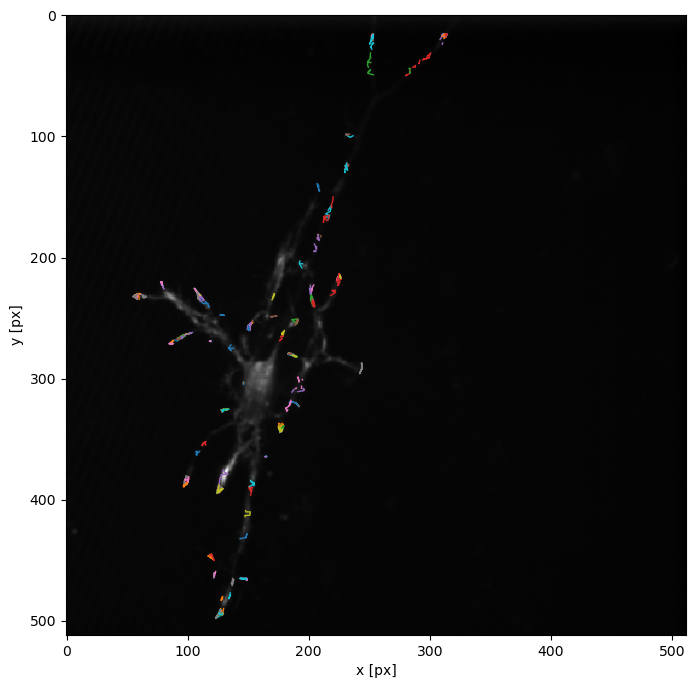

In [51]:
img = tiff.imread(data_folder+'\\'+file_name) 
img_mean = tiff.imread(data_folder+'\\AVG_ridges_2019_02_11_C2_ridges_timelapse4_jttr_blch_corr.tif')

from skimage.exposure import adjust_gamma
img_mean = adjust_gamma(img_mean, gamma=1.5)  # Increase gamma (>1 makes it darker)

# Visualize the trajectories
fig, ax = plt.subplots(figsize = (8,12))  # Create a figure and axes
tp.plot_traj(trajectories,superimpose=img_mean,ax=ax)  # Pass the axes to the plot_traj function

# Modify line properties
import matplotlib.colors as mcolors  # Import color utilities

for line in ax.lines:
    # line.set_linestyle('dashed')  # Dashed lines
    # line.set_marker('o')  # Circular markers
    line.set_markersize(5)  # Marker size
    line.set_linewidth(1)  # Line width
    
    # Preserve original face color
    original_color = line.get_color()  # Get the trajectory color
    line.set_markerfacecolor(original_color)  # Keep face solid

    # Set edge color to transparent black
    transparent_black = (0, 0, 0, 0.5)  # Black with 50% transparency
    line.set_markeredgecolor(transparent_black)  # Apply transparent edges
    line.set_markeredgewidth(1)  # Edge thickness


# Show plot
plt.show()

ax.set_aspect('equal')  # Set equal axis scaling to ensure equal aspect ratio
plt.show()

# Save as SVG with highest resolution
fig.savefig(data_folder+'\\filtered_tracks.svg', format='svg', bbox_inches='tight', dpi = 600)
fig.savefig(data_folder+'\\filtered_tracks.png', format='png', bbox_inches='tight', dpi = 600)

### What's the 1px/frame speed equivalent in #um./min

In [31]:
1*60 / (2.7778 * 2.0), np.min(final_tracks['inst_velocity'])

(10.799913600691195, 3.1333489512145047)

In [13]:
trajectories

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,x_shift,y_shift,frame_shift,displacement,inst_velocity,angular_diff
frame,,,,,,,,,,,,,,,,
4,56.146154,232.125641,5.731180,1.152478,0.254491,1.028673,30.343432,0.001564,4,158,0.000000,0.000000,1.0,0.000000,0.000000,NaN
5,56.879288,231.870394,11.786133,1.226041,0.199722,1.812099,71.750337,0.000656,5,158,-0.255247,0.733135,1.0,0.776297,0.776297,0.038513
6,56.232462,232.045392,6.516647,1.146731,0.281484,1.174251,37.323853,0.001429,6,158,0.174998,-0.646826,1.0,0.670081,0.670081,0.109323
6,69.964940,215.168127,11.249508,1.265856,0.427725,1.783787,64.316772,0.000829,6,205,0.000000,0.000000,1.0,0.000000,0.000000,NaN
7,57.132773,231.087395,5.708162,1.144222,0.247276,1.007323,28.520782,0.001875,7,158,-0.957997,0.900311,1.0,1.314655,1.314655,0.442884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,450.089474,102.378947,14.392253,1.287593,0.183638,2.083089,92.774967,0.001438,296,7217,2.124402,-3.139617,2.0,3.790815,1.895408,0.221331
296,61.933775,228.701987,17.157080,1.294410,0.148360,2.348210,104.831306,0.001272,296,7177,-0.040551,-1.144583,1.0,1.145301,1.145301,0.408960
297,450.057143,104.044898,11.013926,1.269742,0.077446,1.708282,80.424214,0.001970,297,7217,1.665951,-0.032331,1.0,1.666264,1.666264,1.177845


In [14]:
final_tracks

,particle,track_length,track_duration,distance,avg_velocity,inst_velocity,sinuosity,mean_angle
0,158,3.882090,14.0,0.306445,1.313337,16.637529,12.668137,0.184260
1,205,2.781505,14.0,0.094970,0.407013,11.920736,29.288339,0.860163
2,250,9.128417,20.0,1.329168,3.987503,27.385251,6.867769,0.528811
3,318,5.360093,16.0,1.712232,6.420869,20.100347,3.130471,0.932221
4,352,7.695680,22.0,0.055830,0.152265,20.988218,137.840412,0.813962
...,...,...,...,...,...,...,...,...
119,7013,7.196648,20.0,2.444763,7.334290,21.589944,2.943699,0.209242
120,7078,8.046375,20.0,2.128705,6.386116,24.139124,3.779938,0.530871
121,7146,3.277473,14.0,0.535821,2.296375,14.046314,6.116734,0.462453
122,7177,6.981270,18.0,1.048422,3.494741,23.270900,6.658834,0.369996


In [15]:
thresholded_tracks

,particle,track_length,track_duration,distance,avg_velocity,inst_velocity,sinuosity,mean_angle
0,158,3.882090,14.0,0.306445,1.313337,16.637529,12.668137,0.184260
1,205,2.781505,14.0,0.094970,0.407013,11.920736,29.288339,0.860163
2,250,9.128417,20.0,1.329168,3.987503,27.385251,6.867769,0.528811
3,318,5.360093,16.0,1.712232,6.420869,20.100347,3.130471,0.932221
4,352,7.695680,22.0,0.055830,0.152265,20.988218,137.840412,0.813962
...,...,...,...,...,...,...,...,...
119,7013,7.196648,20.0,2.444763,7.334290,21.589944,2.943699,0.209242
120,7078,8.046375,20.0,2.128705,6.386116,24.139124,3.779938,0.530871
121,7146,3.277473,14.0,0.535821,2.296375,14.046314,6.116734,0.462453
122,7177,6.981270,18.0,1.048422,3.494741,23.270900,6.658834,0.369996


## Relative Alignment of track angles

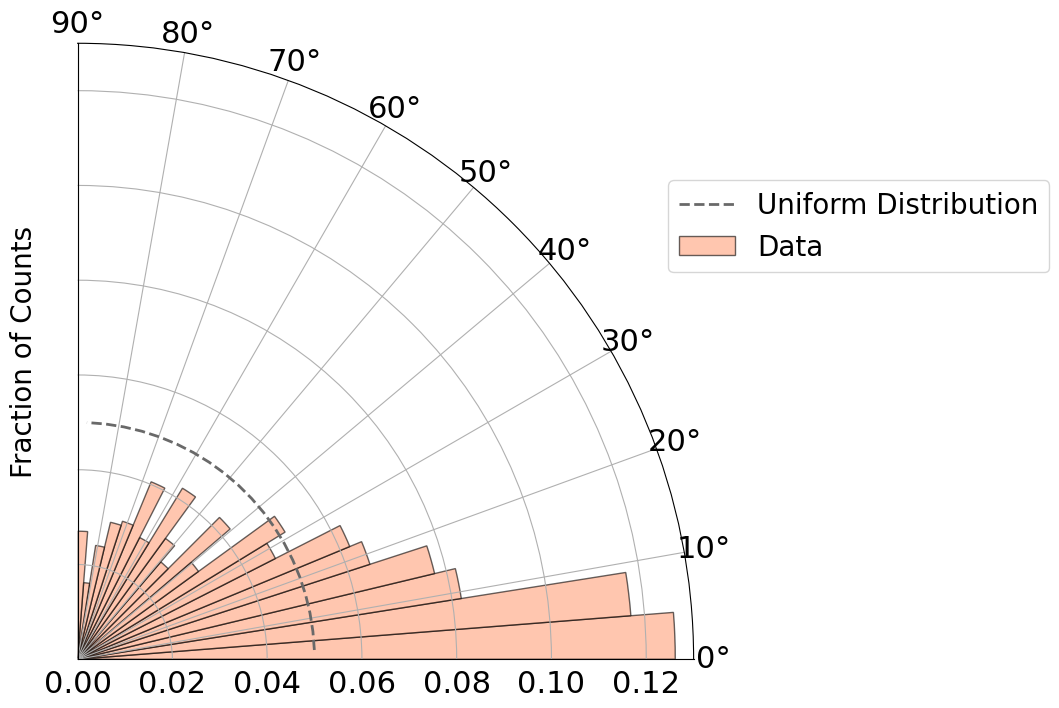

In [113]:
# Ensure angles are in radians
filtered_angles = trajectories['angular_diff']  
filtered_angles = filtered_angles[(filtered_angles >= 0) & (filtered_angles <= np.pi/2)]  # Keep 0 to π/2

# Compute histogram as fraction of total counts
bins = 20
bin_edges = np.linspace(0, np.pi/2, bins + 1)  # Bins in radians
counts, _ = np.histogram(filtered_angles, bins=bin_edges, density=True)  # Normalize counts
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute bin centers in radians

# Compute uniform distribution fraction
uniform_fraction = np.ones_like(bin_centers) * (1 / (np.pi/2))  # Uniform probability

# Create polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))

# Plot histogram as bars
ax.bar(bin_centers, counts / counts.sum(), width=(np.pi/2) / bins, color='lightsalmon', alpha=0.6, edgecolor='black', label="Data")

# Plot uniform distribution as a dashed line
ax.plot(bin_centers, uniform_fraction / uniform_fraction.sum(), linestyle='--', color='dimgrey', linewidth=2, label="Uniform Distribution")

# Set plot properties
ax.set_theta_direction(+1)  # Counterclockwise direction
ax.set_thetamin(0)  # Start at 0 degrees
ax.set_thetamax(90)  # End at 90 degrees
ax.set_rmax(0.13)  # Adjust radial max
ax.set_xticks(np.radians(np.arange(0, 91, 10)))  # X-ticks at 0° to 90°
ax.set_xticklabels([f"{i}°" for i in range(0, 91, 10)], fontsize=22)  # Larger angle labels
ax.set_ylabel("Fraction of Counts", fontsize=20)  # Label y-axis
ax.tick_params(axis='y', labelsize=22)  # Increase radial tick label size
ax.legend(loc='best', bbox_to_anchor=(1, 0., 0.6, 0.8), fontsize=20)


plt.savefig(data_folder+'\\track_alignment_wrt_ridge.svg', format='svg', bbox_inches='tight', dpi = 600)
plt.show()